__Lens Modeling__

I think you'll agree, inversions are a very powerful tool for modeling strong lenses. Now that our source galaxies comprise just a few parameters, we've got a much less complex non-linear parameter space to deal with. This allows us to fit more complex mass models, and thus ask ever more interesting scientific questions!

However, inversions arn't perfect, especially when we use to them model lenses. These arn't huge issues, and they're easy to deal with, but its worth me explaining them now, so they don't trip you up when you start using inversions!

So, what happens if we fit an image using an inversion and the wrong lens model? lets simulate an image and find out.

In [ ]:
%matplotlib inline

from autolens.data import ccd
from autolens.data import simulated_ccd
from autolens.data.array import mask as msk
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.lens import lens_fit
from autolens.lens import lens_data as ld
from autolens.model.inversion import pixelizations as pix
from autolens.model.inversion import regularization as reg
from autolens.lens.plotters import lens_fit_plotters

The usual simulate function.

In [ ]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.from_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
        shape=(180, 180), pixel_scale=0.05, sub_grid_size=2
    )

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
        ),
    )

    source_galaxy = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(0.1, 0.1),
            axis_ratio=0.8,
            phi=90.0,
            intensity=0.2,
            effective_radius=0.3,
            sersic_index=1.0,
        ),
    )

    tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
        galaxies=[lens_galaxy, source_galaxy],
        image_plane_grid_stack=image_plane_grid_stack,
    )

    return simulated_ccd.SimulatedCCDData.from_tracer_and_exposure_arrays(
        tracer=tracer,
        pixel_scale=0.05,
        exposure_time=300.0,
        psf=psf,
        background_sky_level=0.1,
        add_noise=True,
    )

And the same fitting function as the last tutorial.

In [ ]:
def perform_fit_with_lens_and_source_galaxy(lens_galaxy, source_galaxy):

    ccd_data = simulate()
    mask = msk.Mask.circular_annular(
        shape=ccd_data.shape,
        pixel_scale=ccd_data.pixel_scale,
        inner_radius_arcsec=0.5,
        outer_radius_arcsec=2.2,
    )

    lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)

    tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
        galaxies=[lens_galaxy, source_galaxy],
        image_plane_grid_stack=lens_data.grid_stack,
        border=lens_data.border,
    )

    return lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

This lens galaxy has the wrong mass-model -  I've reduced its Einstein Radius from 1.6 to 0.8.

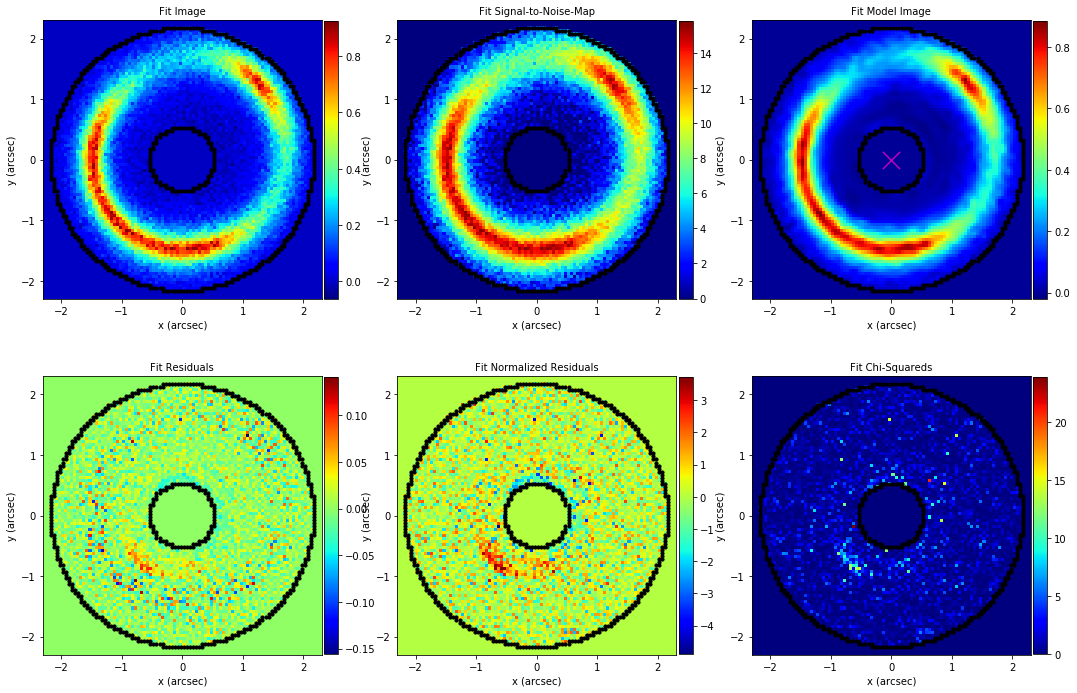

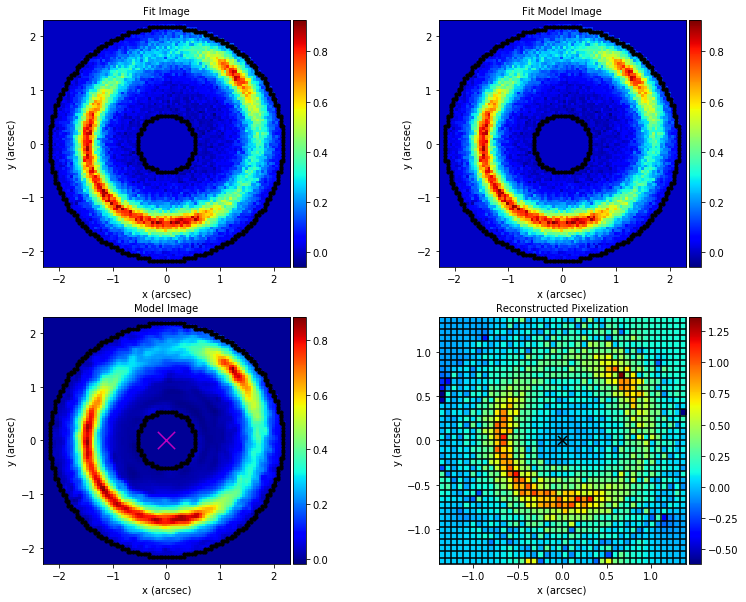

In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=0.8
    ),
)

source_galaxy = g.Galaxy(
    redshift=1.0,
    pixelization=pix.Rectangular(shape=(40, 40)),
    regularization=reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_lens_and_source_galaxy(
    lens_galaxy=lens_galaxy, source_galaxy=source_galaxy
)

lens_fit_plotters.plot_fit_subplot(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

What happened!? This incorrect mass-model provides a really good_fit to the image! The residuals and chi-squared map are as good as the ones we saw in the last tutorial.

How can an incorrect lens model provide such a fit? Well, as I'm sure you noticed, the source has been reconstructed as a demagnified version of the image. Clearly, this isn't a physical solution or a solution that we want our non-linear search to find, but for inversions these solutions nevertheless exist.

This isn't necessarily problematic for lens modeling. Afterall, the source reconstruction above is extremely complex, in that it requires a lot of pixels to fit the image accurately. Indeed, its Bayesian evidence is much lower than the correct solution.

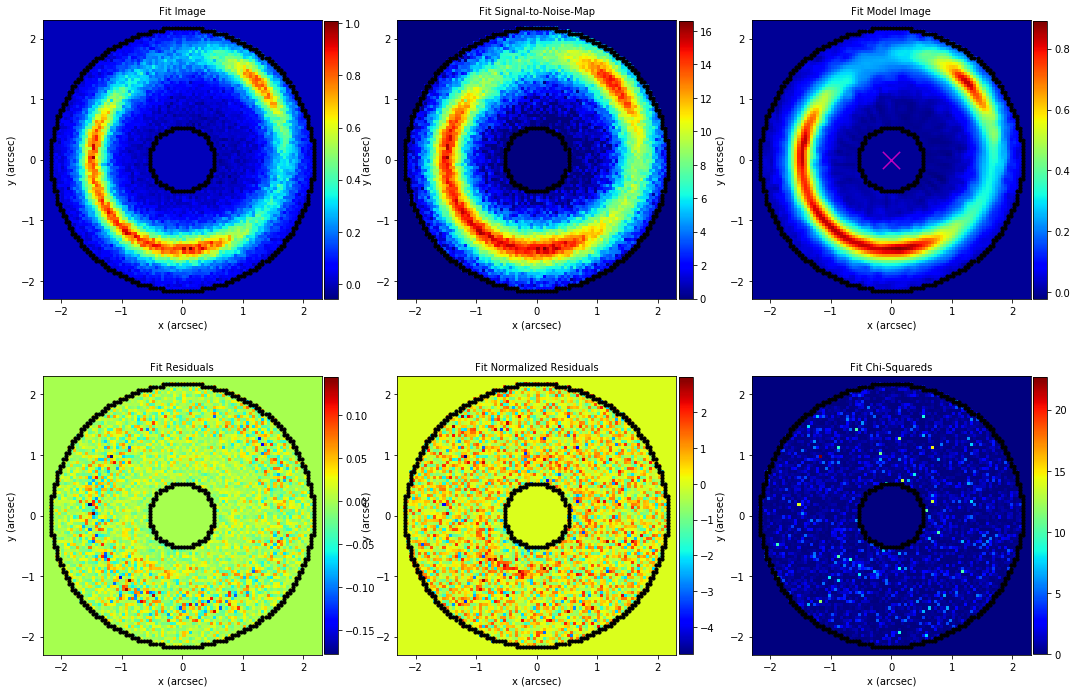

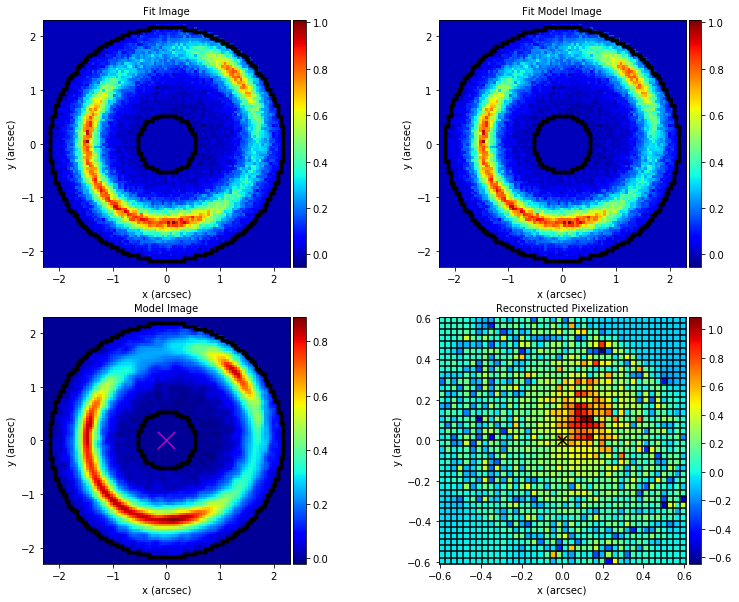

Bayesian Evidence of Incorrect Fit:
9511.27378135678
Bayesian Evidence of Correct Fit:
10412.508427484965


In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
    ),
)

source_galaxy = g.Galaxy(
    redshift=1.0,
    pixelization=pix.Rectangular(shape=(40, 40)),
    regularization=reg.Constant(coefficient=1.0),
)

correct_fit = perform_fit_with_lens_and_source_galaxy(
    lens_galaxy=lens_galaxy, source_galaxy=source_galaxy
)

lens_fit_plotters.plot_fit_subplot(
    fit=correct_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=correct_fit,
    should_plot_mask=True,
    extract_array_from_mask=True,
    zoom_around_mask=True,
)

print("Bayesian Evidence of Incorrect Fit:")
print(fit.evidence)
print("Bayesian Evidence of Correct Fit:")
print(correct_fit.evidence)

Indeed, its evidence *is* lower. However, the difference in evidence isn't *that large*. This is going to be a problem for our non-linear search, as its suddenly going to see *a lot* of solutions with really high evidences. Furthermore, these solutions occupy the *vast majority* of parameter space (e.g. every single lens model that is wrong). This makes it easy for the non-linear search to get lost searching through these unphysical solutions and, unfortunately, infer an incorrect lens model (or, in non-linear speak, a local maxima).

There is no simple fix for this. The reality is, when we use an inversion, these solutions exist. This is infact why pipelines were initially conceived - as they offer a simple solution to this problem. We can simply build a pipeline that begins by modeling the source galaxy as a light profile, 'initializing' our lens mass model. Then, when we switch to an inversion in the next phase, our mass model starts in the correct regions of parameter space and doesn't get lost sampling these incorrect solutions.

Its not ideal - but with pipelines, its also not a big problem. Furthermore, light-profiles run faster computationally than inversions, so we'd probably want to do this anyway!

Okay, so we've covered incorrect solutions, lets end by noting that we can model profiles and inversions at the same time. We do this when we want to simultaneously fit and subtract the light of a lens galaxy and reconstruct its lensed source using an inversion. To do this, all we have to do is give the lens galaxy a light profile.


In [ ]:
def simulate_lens_with_light_profile():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.from_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(
        shape=(180, 180), pixel_scale=0.05, sub_grid_size=2
    )

    lens_galaxy = g.Galaxy(
        redshift=0.5,
        light=lp.SphericalSersic(
            centre=(0.0, 0.0), intensity=0.2, effective_radius=0.8, sersic_index=4.0
        ),
        mass=mp.EllipticalIsothermal(
            centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
        ),
    )

    source_galaxy = g.Galaxy(
        redshift=1.0,
        light=lp.EllipticalSersic(
            centre=(0.1, 0.1),
            axis_ratio=0.8,
            phi=90.0,
            intensity=0.2,
            effective_radius=0.3,
            sersic_index=1.0,
        ),
    )

    tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
        galaxies=[lens_galaxy, source_galaxy],
        image_plane_grid_stack=image_plane_grid_stack,
    )

    return simulated_ccd.SimulatedCCDData.from_tracer_and_exposure_arrays(
        tracer=tracer,
        pixel_scale=0.05,
        exposure_time=300.0,
        psf=psf,
        background_sky_level=0.1,
        add_noise=True,
    )

When fitting such an image, we now want to include the lens's light in the analysis. thus, we should update our mask to be circular, and include the central regions of the image.

In [ ]:
ccd_data = simulate_lens_with_light_profile()

mask = msk.Mask.circular(
    shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, radius_arcsec=2.5
)

As I said above, performing this fit is the same as usual, we just give the lens galaxy a light profile.

In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    light=lp.SphericalSersic(
        centre=(0.0, 0.0), intensity=0.2, effective_radius=0.8, sersic_index=4.0
    ),
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
    ),
)

These are all the usual things we do when setting up a fit.

In [ ]:
source_galaxy = g.Galaxy(
    redshift=1.0,
    pixelization=pix.Rectangular(shape=(40, 40)),
    regularization=reg.Constant(coefficient=1.0),
)

lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy, source_galaxy],
    image_plane_grid_stack=lens_data.grid_stack,
    border=lens_data.border,
)

This fit subtracts the lens galaxy's light from the image and fits the resulting source-only image with the inversion. When we plot the image, a new panel on the sub-plot appears showing the model image of the lens galaxy.

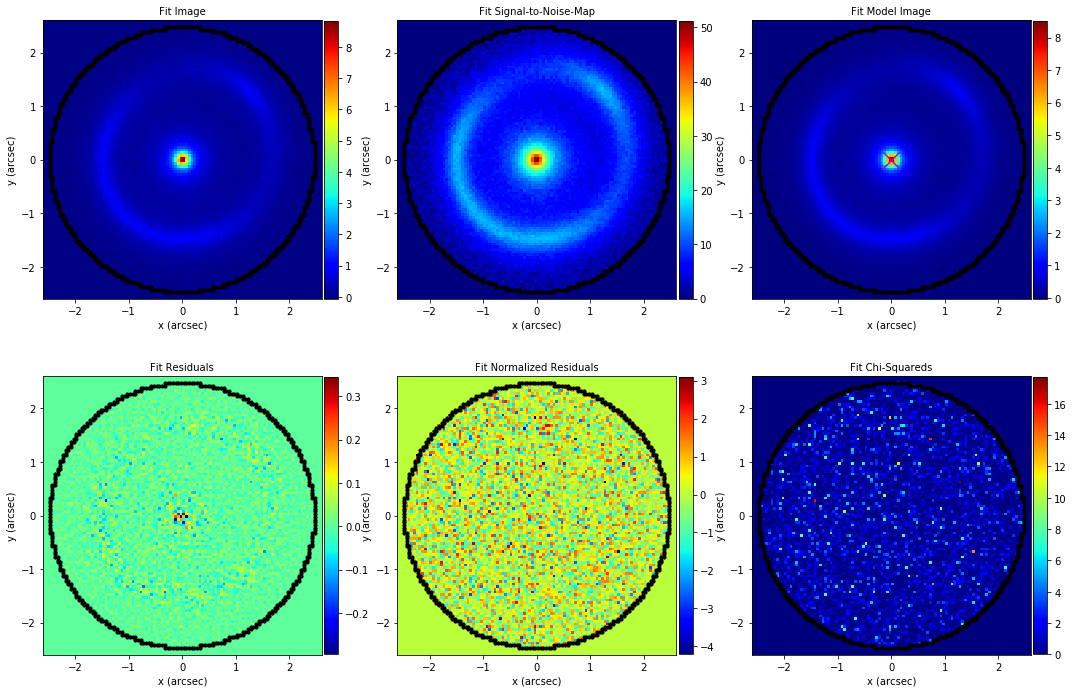

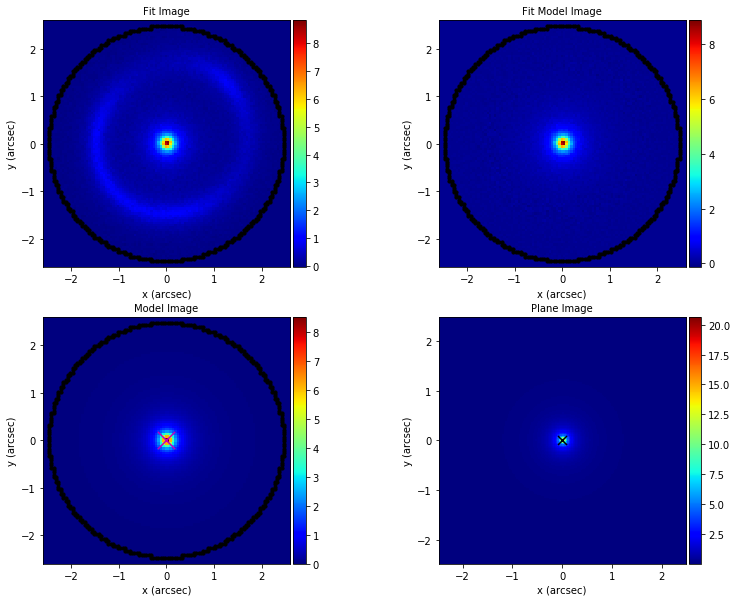

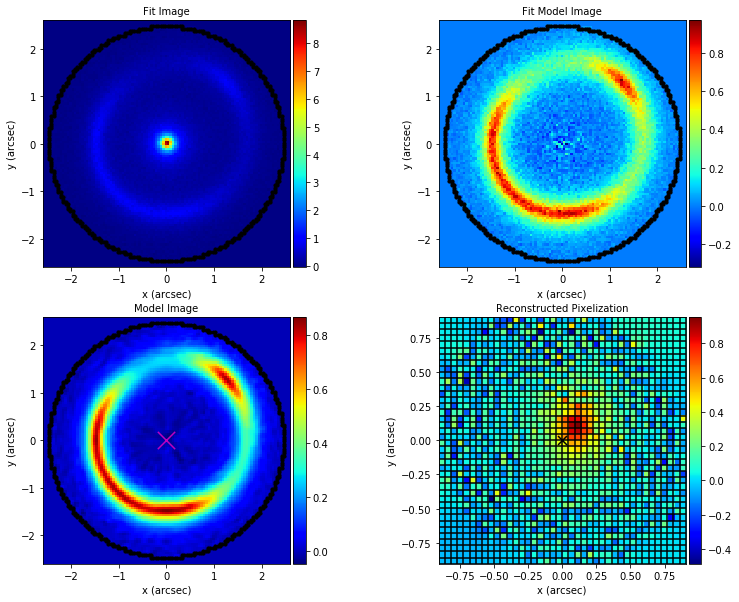

In [ ]:
fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

Of course if the lens subtraction is rubbish, so is our fit, so we can be sure that our lens model wants to fit the lens galaxy's light accurately (below, I've increased the lens galaxy intensity from 0.2 to 0.3)!

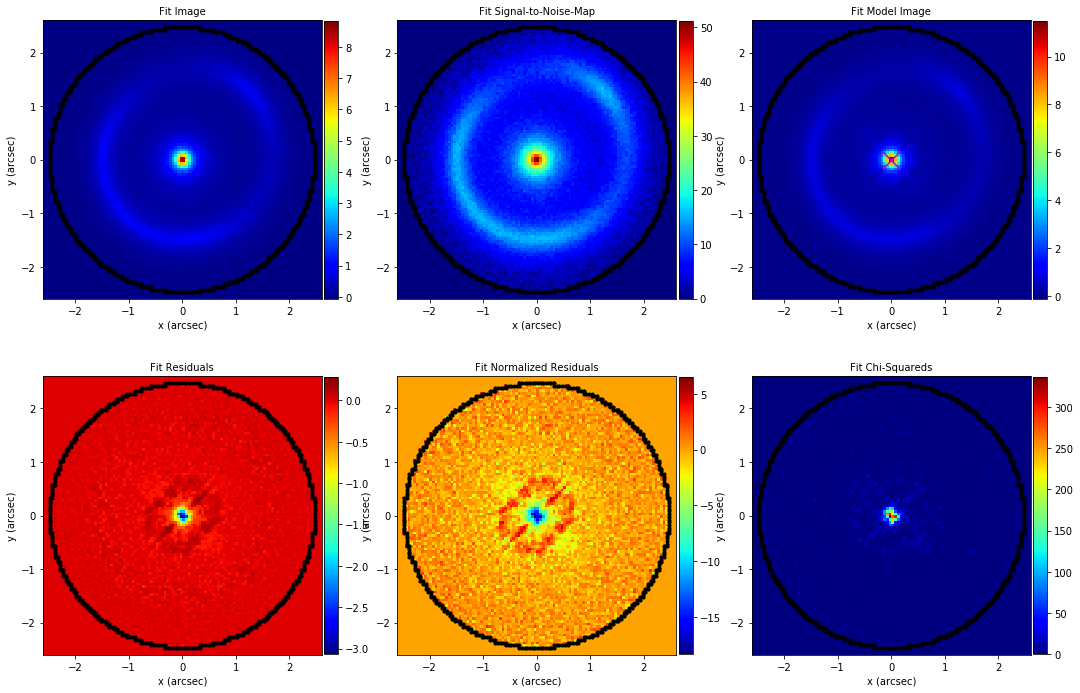

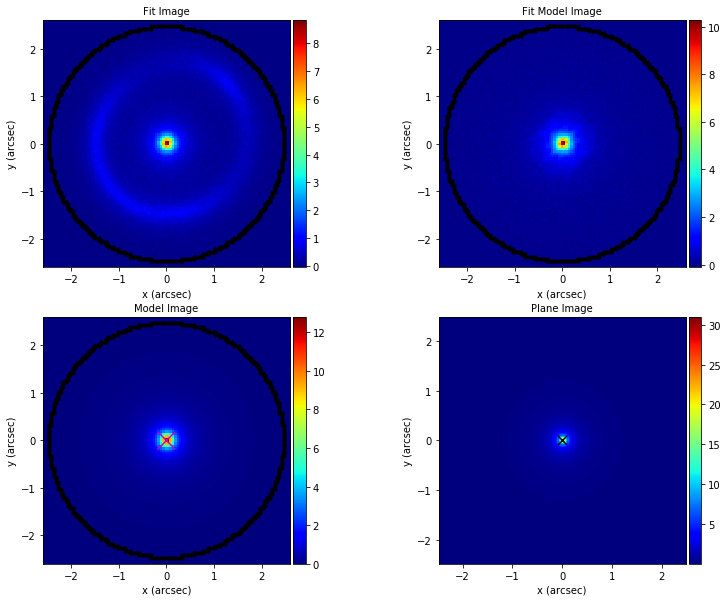

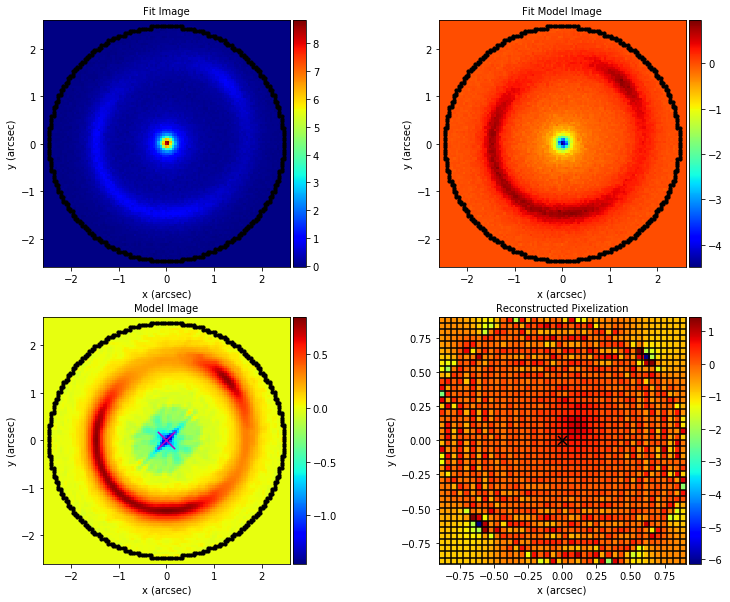

In [ ]:
lens_galaxy = g.Galaxy(
    redshift=0.5,
    light=lp.SphericalSersic(
        centre=(0.0, 0.0), intensity=0.3, effective_radius=0.8, sersic_index=4.0
    ),
    mass=mp.EllipticalIsothermal(
        centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=1.6
    ),
)

tracer = ray_tracing.Tracer.from_galaxies_and_image_plane_grid_stack(
    galaxies=[lens_galaxy, source_galaxy],
    image_plane_grid_stack=lens_data.grid_stack,
    border=lens_data.border,
)

fit = lens_fit.LensDataFit.for_data_and_tracer(lens_data=lens_data, tracer=tracer)

lens_fit_plotters.plot_fit_subplot(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

lens_fit_plotters.plot_fit_subplot_of_planes(
    fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True
)

And with that, we're done. We've pretty much covered everything inversion related, so in the last tutorial I'll set you up with a pipeline that you can use to model lenses with an inversion.

But first, I just want to point out a few things about what we've covered - to get you thinking about the next chapter, adaption.

- The unphysical solutions above are clearly problematic. Whilst they have lower Bayesian evidences, their exsistance will still impact our inferences on the error-bars of our lens model. However, the pixelization's that we used in this chapter are not adapted to the images they are fitting, and this means that the correct solutions achieve much lower Bayesian evidence values than is actually possible. Thus, once we've covered adaption, these issues will have completely been resolved!

- When the lens galaxy's light is subtracted perfectly, it leaves no residuals. However, if it isn't subtracted perfectly, it does leave residuals, and these residuals will be fitted by the inversion. If the residual are significant, this is going to really mess-up our source reconstruction and can lead to some pretty nasty systematics. In the next chapter, we'll learn how our adaptive analysis can prevent this residual fitting.